Pythonコード: 1000状態ランダムウォーク + n-ステップセミ勾配TD

In [6]:
import numpy as np

# 環境設定
class RandomWalkEnv:
    def __init__(self, num_states=1000, group_size=50):
        self.num_states = num_states  # 状態数
        self.group_size = group_size  # グループのサイズ（状態集約）
        self.terminal_left = 0  # 左端の終端状態
        self.terminal_right = num_states + 1  # 右端の終端状態
        self.reset()

    def reset(self):
        self.state = self.num_states // 2  # 中央から開始
        return self.state

    def step(self, action):
        """
        action: -1 (左) または 1 (右)
        """
        if action not in [-1, 1]:
            raise ValueError("Action must be -1 (left) or 1 (right)")
        
        # 次の状態を決定
        self.state += action
        if self.state == self.terminal_left:
            return self.state, -1, True  # 左端に到達 → 報酬 -1
        elif self.state == self.terminal_right:
            return self.state, 1, True  # 右端に到達 → 報酬 +1
        else:
            return self.state, 0, False  # 中間状態 → 報酬 0

    def is_terminal(self, state):
        return state == self.terminal_left or state == self.terminal_right

# 特徴ベクトル作成（状態集約）
def create_features(state, num_states, group_size):
    features = np.zeros(num_states // group_size)
    group = (state - 1) // group_size
    if 0 <= group < len(features):
        features[group] = 1
    return features

# n-ステップセミ勾配TDアルゴリズム
def n_step_semi_gradient_td_optimized(env, n, alpha, gamma, num_episodes, group_size):
    num_features = env.num_states // group_size
    w = np.zeros(num_features)  # 重みベクトル（初期化）
    
    # 特徴ベクトルのキャッシュ
    all_features = [create_features(s, env.num_states, group_size) for s in range(env.num_states + 2)]
    
    for episode in range(num_episodes):
        # 初期化
        state = env.reset()
        states = [state]
        rewards = []
        features = [all_features[state]]

        t = 0  # 時刻
        T = float('inf')  # 終了時刻
        
        while True:
            if t < T:
                # 行動をランダムに選択（左右に等確率で移動）
                action = np.random.choice([-1, 1])
                next_state, reward, done = env.step(action)
                rewards.append(reward)
                states.append(next_state)
                features.append(all_features[next_state])
                
                if done:
                    T = t + 1
            
            tau = t - n + 1
            if tau >= 0:
                # 累積報酬（効率化）
                G = sum(gamma ** (i - tau) * rewards[i] for i in range(tau, min(tau + n, T)))
                if tau + n < T:
                    # 予測値の計算
                    G += gamma ** n * np.dot(w, features[tau + n])

                # 重み更新
                w += alpha * (G - np.dot(w, features[tau])) * features[tau]
            
            if tau == T - 1:
                break

            t += 1

    return w


# パラメータ設定
num_states = 1000
group_size = 50
gamma = 0.9
alpha = 0.1
n = 4
num_episodes = 100

# 環境作成と学習
env = RandomWalkEnv(num_states, group_size)
w = n_step_semi_gradient_td_optimized(env, n, alpha, gamma, num_episodes, group_size)

# 学習結果表示
print("Learned weights:", w)


Learned weights: [-2.99754100e-001 -6.36567980e-008 -2.38627782e-029 -6.50180245e-039
 -3.90805548e-067 -8.27310870e-075 -1.19282662e-084 -3.36330455e-096
 -1.45526950e-112  3.50302146e-121  4.83134718e-099  3.41678328e-082
  1.04998811e-083  4.84721336e-052  1.75702481e-041  3.81561263e-043
  5.64378138e-026  2.62978908e-012  7.77922953e-012  2.99754100e-001]


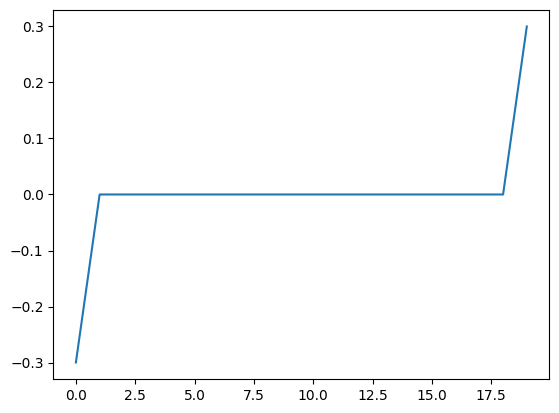

In [7]:
import matplotlib.pyplot as plt
plt.plot(w)

In [10]:
all_features

NameError: name 'all_features' is not defined